In [ ]:
!pip install datasets

In [1]:
import torch
import re
import torch.nn.functional as F
import re
import numpy as np
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/angel/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        #self.output_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        #embeddings = self.embedding(x)
        #output = self.output_layer(embeddings)

        return self.embeddings(X)

In [24]:
from datasets import load_dataset

class WordsDataset(torch.utils.data.Dataset):
    
    def __init__(self, context_window, k):
        self.dataset = load_dataset('large_spanish_corpus', name='all_wikis', split='train')[:100000]
        self.tokenizer = get_tokenizer('basic_english')

        self.count_words()

        self.vocab = build_vocab_from_iterator(map(self.tokenizer, self.dataset['text']), specials=['<unk>'], min_freq=1, max_tokens=90000)
        self.vocab.set_default_index(self.vocab["<unk>"])

        self.context_window = context_window
        self.k = k
        self.temperature = 10e-5

        print(f'Len of vocab {len(self.vocab)}')

        self.build_dataset()

    def count_words(self):
        self.freq = {}
        for document in self.dataset['text']:
            document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
            tokens = self.tokenizer(document)
    
            for word in tokens:
                if word in self.freq:
                    self.freq[word] += 1
                else:
                    self.freq[word] = 1

        self.total= sum(self.freq.values())

    def build_dataset(self):
        self.X = []
        self.y = []

        for document in self.dataset['text']:
          document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
          tokens = self.tokenizer(document)

          for i, word in enumerate(tokens):
              center = word

              if i < self.context_window:
                  continue
              elif i > len(tokens) - self.context_window - 1:
                  continue
              else:
                  context = tokens[i - self.context_window:i] + tokens[i + 1:i + self.context_window + 1]

              for word in context:
                subsample_probability = 1 - np.sqrt(self.temperature / (self.freq[center] / self.total))

                if np.random.rand() < subsample_probability:
                    continue

                if self.vocab[center] == self.vocab["<unk>"] or self.vocab[word] == self.vocab["<unk>"]:
                    continue

                self.X.append(self.vocab([center, word]))
                self.y.append(1)

                if len(self.X) % 1000000 == 0:
                    print(f'Center: {center} - Context: {word}')

        self.X = torch.tensor(self.X).long()
        self.y = torch.tensor(self.y).squeeze().long()

        print(self.X.shape)
        print(self.y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
embedding_size = 300
context_window = 5
batch_size = 1024
k = 5

In [26]:
from torch.utils.data import DataLoader

word_dataset = WordsDataset(context_window, k)
dataloader = DataLoader(word_dataset, batch_size=batch_size, shuffle=True)

print(f'Number of samples: {len(word_dataset.dataset["text"])}')

Found cached dataset large_spanish_corpus (/home/angel/.cache/huggingface/datasets/large_spanish_corpus/all_wikis/1.1.0/866aa19decb2ee81eed3e918e7150937330cc993815e36beda5f40a992058639)


Len of vocab 89826
Center: cableado - Context: de
Center: realizadas - Context: estudiantes
Center: esponjas - Context: la
Center: compresión - Context: esfuerzos
torch.Size([4645296, 2])
torch.Size([4645296])
Number of samples: 100000


In [27]:
model = SkipGram(len(word_dataset.vocab), embedding_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [28]:
for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = y.squeeze().to(device)

    print(X.shape)
    print(y.shape)

    break

torch.Size([1024, 2])
torch.Size([1024])


In [29]:
model(X).shape

torch.Size([1024, 2, 300])

In [31]:
embeddings = model(X)
center = embeddings[:, 0]
context = embeddings[:, 1]

negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
negative_samples = model(negative_samples_indices)
    
loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
loss = loss / X.shape[0]

loss

tensor(7.0240, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
for i in range(X.shape[0]):
    center = word_dataset.vocab.lookup_token(X[i].item())
    context =  word_dataset.vocab.lookup_token(y[i].item())

    print(f'Center: {center} - Context: {context}')


ValueError: only one element tensors can be converted to Python scalars

In [23]:
for epoch in range(150):
    # Compute prediction error
    embeddings = model(X)
    center = embeddings[:, 0]
    context = embeddings[:, 1]

    negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    negative_samples = model(negative_samples_indices)
        
    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
    loss = loss / X.shape[0]
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}]")

epoch 0 loss: 0.062783  [ 1024/22119]
epoch 1 loss: 0.029171  [ 1024/22119]
epoch 2 loss: 0.057691  [ 1024/22119]
epoch 3 loss: 0.046338  [ 1024/22119]
epoch 4 loss: 0.037493  [ 1024/22119]
epoch 5 loss: 0.071149  [ 1024/22119]
epoch 6 loss: 0.006107  [ 1024/22119]
epoch 7 loss: 0.011837  [ 1024/22119]
epoch 8 loss: 0.013878  [ 1024/22119]
epoch 9 loss: 0.045962  [ 1024/22119]
epoch 10 loss: 0.056235  [ 1024/22119]
epoch 11 loss: 0.031882  [ 1024/22119]
epoch 12 loss: 0.023467  [ 1024/22119]
epoch 13 loss: 0.018987  [ 1024/22119]
epoch 14 loss: 0.037658  [ 1024/22119]
epoch 15 loss: 0.085074  [ 1024/22119]
epoch 16 loss: 0.044247  [ 1024/22119]
epoch 17 loss: 0.015512  [ 1024/22119]
epoch 18 loss: 0.029549  [ 1024/22119]
epoch 19 loss: 0.057593  [ 1024/22119]
epoch 20 loss: 0.052241  [ 1024/22119]
epoch 21 loss: 0.017237  [ 1024/22119]
epoch 22 loss: 0.008480  [ 1024/22119]
epoch 23 loss: 0.034251  [ 1024/22119]
epoch 24 loss: 0.053499  [ 1024/22119]
epoch 25 loss: 0.035101  [ 1024/221

In [34]:
for epoch in range(150):
  for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = y.squeeze().to(device)

    # Compute prediction error
    embeddings = model(X)
    center = embeddings[:, 0]
    context = embeddings[:, 1]

    negative_samples_indices = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    negative_samples = model(negative_samples_indices)
        
    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(torch.matmul(center, context.T))))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(torch.matmul(center, negative_samples.T)))))
    loss = loss / X.shape[0]

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}]")


epoch 0 loss: 3.697280  [ 1024/4645296]
epoch 0 loss: 2.941358  [1025024/4645296]
epoch 0 loss:     nan  [2049024/4645296]
epoch 0 loss:     nan  [3073024/4645296]
epoch 0 loss:     nan  [4097024/4645296]
epoch 1 loss:     nan  [ 1024/4645296]
epoch 1 loss:     nan  [1025024/4645296]
epoch 1 loss:     nan  [2049024/4645296]
epoch 1 loss:     nan  [3073024/4645296]
epoch 1 loss:     nan  [4097024/4645296]
epoch 2 loss:     nan  [ 1024/4645296]
epoch 2 loss:     nan  [1025024/4645296]
epoch 2 loss:     nan  [2049024/4645296]
epoch 2 loss:     nan  [3073024/4645296]
epoch 2 loss:     nan  [4097024/4645296]
epoch 3 loss:     nan  [ 1024/4645296]
epoch 3 loss:     nan  [1025024/4645296]
epoch 3 loss:     nan  [2049024/4645296]
epoch 3 loss:     nan  [3073024/4645296]
epoch 3 loss:     nan  [4097024/4645296]
epoch 4 loss:     nan  [ 1024/4645296]
epoch 4 loss:     nan  [1025024/4645296]
epoch 4 loss:     nan  [2049024/4645296]
epoch 4 loss:     nan  [3073024/4645296]
epoch 4 loss:     nan  [

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# load model weights
model = CBoW(len(word_dataset.vocab), embedding_size).to(device)
model.load_state_dict(torch.load('model_weights.pth'))

In [72]:
words = word_dataset.vocab(['rey', 'hombre', 'mujer', 'reina'])
print(words)

words_tensor = torch.tensor(words).to(device)
embeddings = model.embedding(words_tensor)

analogy_vector = embeddings[1] - embeddings[0] + embeddings[2]

embedding_matrix = torch.clone(model.embedding.weight)
embedding_matrix[words[:-1], :] = 0

result = torch.argmax(torch.matmul(embedding_matrix, analogy_vector))
print(result)
word_dataset.vocab.lookup_token(result.item())

[1541, 570, 825, 10147]
tensor(68288, device='cuda:0')


'lamasu'

In [58]:
model.output_layer.weight.shape

AttributeError: 'SkipGram' object has no attribute 'output_layer'

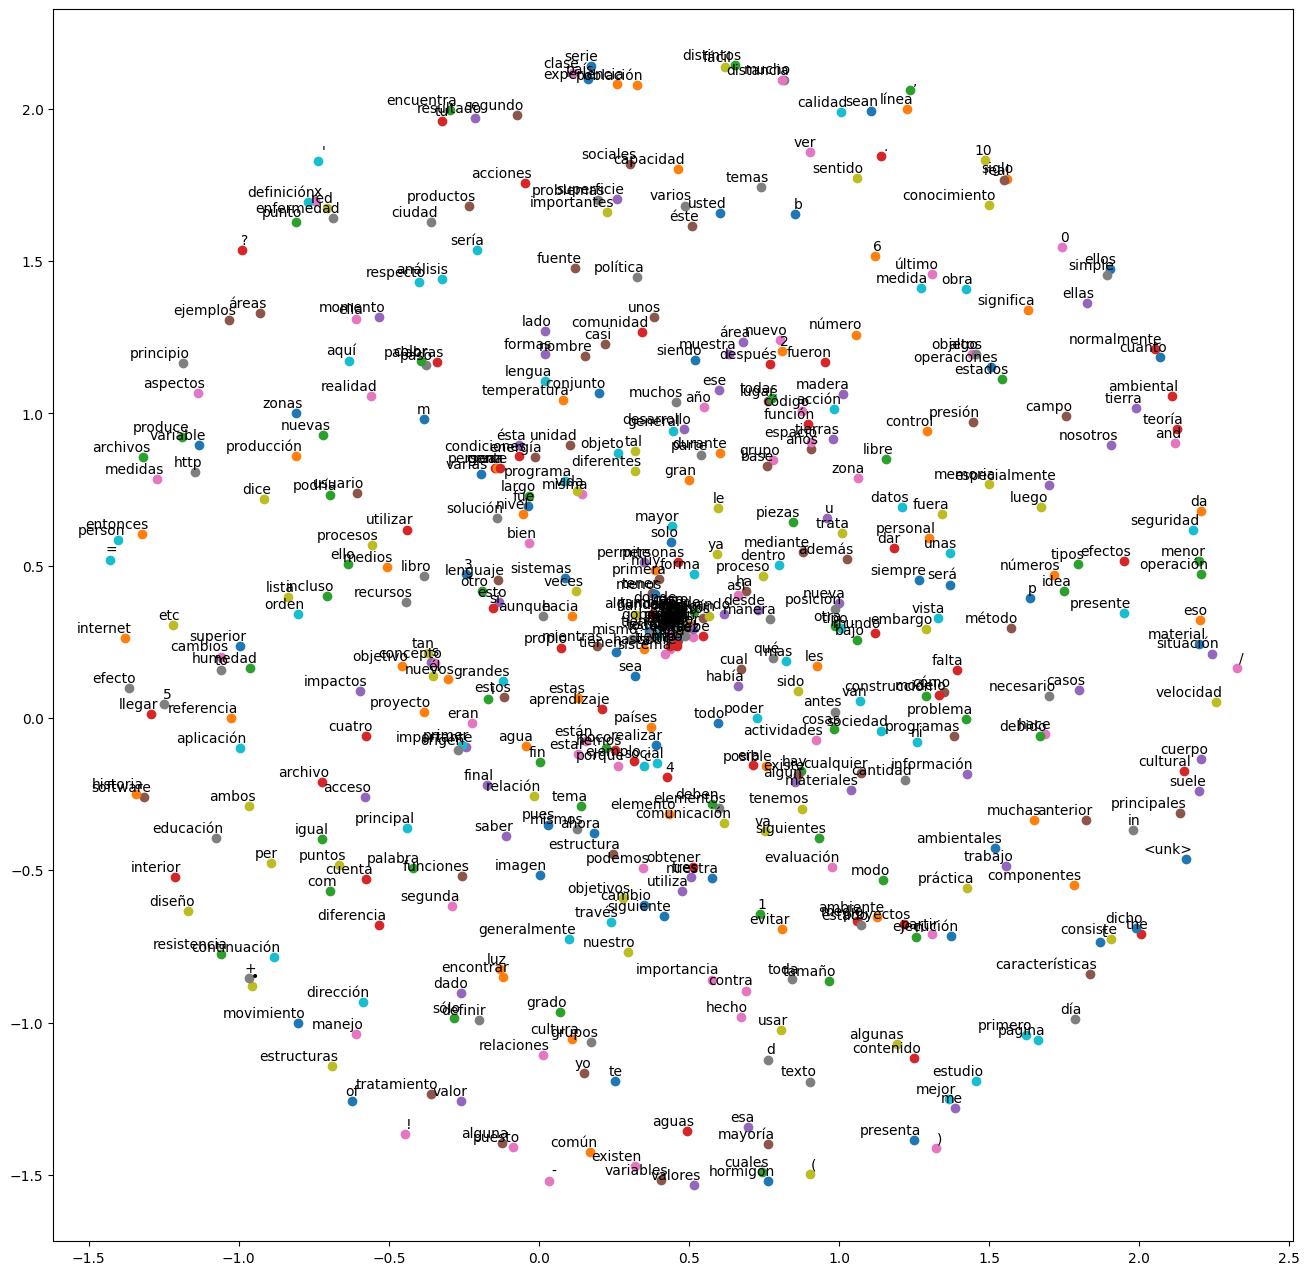

In [73]:
# visualize embeddings of the first 1000 words
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings = tsne.fit_transform(model.embedding.weight.detach().cpu().numpy()[:500, :])

plt.figure(figsize=(16, 16))
for i, label in enumerate(word_dataset.vocab.lookup_token(idx) for idx in range(500)):
    x, y = embeddings[i, :]

    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()  
